<a href="https://colab.research.google.com/github/leoquiroa/LoanRisk/blob/master/FICO_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, f1_score

from catboost import Pool, CatBoostClassifier

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# The shareable link
link_x = 'https://drive.google.com/open?id=11cliuBAQTUsPQdwo8bwQUro-y8_OWHA-' 
link_y = 'https://drive.google.com/open?id=1UB-SX1JJU1_AimlP4ymc3vnXdra8rvZq'

In [0]:
def get_df(link):
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('file.csv')
  df = pd.read_csv('file.csv')
  return df.drop(['ix'], axis=1)

Read data

In [0]:
X = get_df(link_x)
X.head()

acc_open_past_24mths addr_state  ...  total_rev_hi_lim  verification_status
0                   3.0         OK  ...             500.0             Verified
1                  15.0         FL  ...           52400.0      Source Verified
2                   5.0         NH  ...            6200.0         Not Verified
3                   2.0         AL  ...            8800.0      Source Verified
4                   3.0         WA  ...           31000.0      Source Verified

[5 rows x 87 columns]

In [0]:
def fico_letter(row):
    if (row >= 630 and row <= 689): return 'Fair'
    elif row >= 690 and row <= 719: return 'Good'
    elif row >= 720 and row <= 850: return 'Excellent'

In [0]:
X['fico_letter'] = X['fico_range_low'].apply(fico_letter) 
X['fico_letter'].value_counts()
y = X['fico_letter']

Model

In [0]:
def split_data(X,y,type_risk):
  X_mod = X[X.grade == type_risk].copy()
  X_mod = X_mod.drop(['grade', 'int_rate','fico_range_low','fico_letter'], axis=1, errors='ignore')
  y_mod = y[X_mod.index]

  X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, stratify=y_mod, random_state=0)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)
  return [X_train,X_val,X_test,y_train,y_val,y_test]

In [0]:
def pooling(X_train,X_val,X_test,y_train,y_val,y_test):
  cat_feat_ind = (X_train.dtypes == 'object').to_numpy().nonzero()[0]
  pool_train = Pool(X_train, y_train, cat_features=cat_feat_ind)
  pool_val = Pool(X_val, y_val, cat_features=cat_feat_ind)
  pool_test = Pool(X_test, y_test, cat_features=cat_feat_ind)
  return [pool_train,pool_val,pool_test]

In [0]:
def fit_model(y_train,pool_train,pool_val):
  n = y_train.value_counts()
  n_min = n.min()
  model = CatBoostClassifier(iterations=1000,
                             learning_rate=0.03,
                             depth=2,
                             early_stopping_rounds=100,
                             loss_function='MultiClass',
                            #class_weights=[n_min/n[0], n_min/n[1], n_min/n[2]],
                            verbose=False,
                            random_state=0
                            )
  model.fit(pool_train, eval_set=pool_val, plot=True)
  return model

In [0]:
def calculate_risk(type_risk):
  [X_train,X_val,X_test,y_train,y_val,y_test] = split_data(X,y,type_risk)
  [pool_train,pool_val,pool_test] = pooling(X_train,X_val,X_test,y_train,y_val,y_test)
  model = fit_model(y_train,pool_train,pool_val)
  y_pred_test = model.predict(pool_test)
  print(pd.DataFrame(y_pred_test)[0].value_counts())
  print(y_test.value_counts())
  return accuracy_score(y_test, y_pred_test)

In [0]:
# Min Weight
calculate_risk('A')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Good         16645
Excellent    15295
Fair          1855
Name: 0, dtype: int64
Excellent    20605
Good          8599
Fair          4591
Name: fico_letter, dtype: int64


0.709217339843172

In [0]:
# No Weight
calculate_risk('A')

Excellent    46360
Good         19347
Fair         10329
Name: fico_letter, dtype: int64


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Excellent    22659
Good          7848
Fair          3288
Name: 0, dtype: int64
Excellent    20605
Good          8599
Fair          4591
Name: fico_letter, dtype: int64


0.778221630418701

In [0]:
# No Weight
calculate_risk('E')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fair         3447
Good         1105
Excellent     188
Name: 0, dtype: int64
Fair         2930
Good         1421
Excellent     389
Name: fico_letter, dtype: int64


0.7369198312236287

In [0]:
# Min Weight
calculate_risk('E')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Good    2971
Fair    1769
Name: 0, dtype: int64
Fair         2930
Good         1421
Excellent     389
Name: fico_letter, dtype: int64


0.6063291139240506

In [0]:
print(y_test.value_counts())

Excellent    20605
Good          8599
Fair          4591
Name: fico_letter, dtype: int64


In [0]:
preds_proba = model.predict_proba(pool_test)
preds_proba

array([[0.00251023, 0.98122863, 0.01626114],
       [0.01062481, 0.93140194, 0.05797325],
       [0.4320074 , 0.3878609 , 0.1801317 ],
       ...,
       [0.00474264, 0.97628092, 0.01897644],
       [0.06221243, 0.82499189, 0.11279568],
       [0.14408677, 0.66859378, 0.18731945]])

In [0]:
a = pd.DataFrame(y_pred_test)[0].value_counts()
print(a)

Fair         4064
Excellent     676
Name: 0, dtype: int64


[Text(0, 0.5, 'total'), Text(0.5, 0, 'FICO type')]

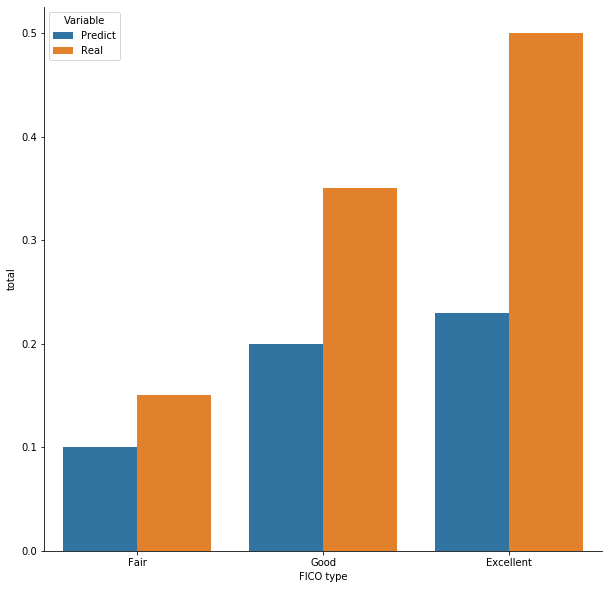

In [0]:
df = pd.DataFrame({
    'Factor': ['Fair', 'Good', 'Excellent'],
    'Predict': [0.10, 0.20, 0.23],
    'Real': [0.15, 0.35, 0.5]
})
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = df.melt(id_vars='Factor').rename(columns=str.title)
ax = sns.barplot(x='Factor', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)
ax.set(xlabel='FICO type', ylabel='total')

In [0]:
type(good)

pandas.core.series.Series